# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Titanic RAMP](http://www.ramp.studio/problems/titanic): survival prediction of Titanic passengers

_Benoit Playe (Institut Curie/Mines ParisTech), Chloé-Agathe Azencott (Institut Curie/Mines ParisTech), Alex Gramfort (LTCI/Télécom ParisTech), Balázs Kégl (LAL/CNRS)_

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify people who survived from the sinking of the Titanic, based on gender, age, and ticketing information**. 

The data we will manipulate is from the [Titanic kaggle challenge](https://www.kaggle.com/c/titanic-gettingStarted).

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename)
y_train = data['Survived'].values
X_train = data.drop(['Survived', 'PassengerId'], axis=1)
X_train.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S
1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.000,NaN,S
2,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S
3,3,"Torber, Mr. Ernst William",male,44.0,0,0,364511,8.050,NaN,S
4,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.000,NaN,S


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,356.000000,356.000000,356.000000,290.000000,356.000000,356.000000,356.000000
mean,451.713483,0.384831,2.300562,29.123862,0.550562,0.412921,31.657970
std,260.505039,0.487240,0.833861,14.103122,1.120978,0.798415,43.474154
min,7.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,229.750000,0.000000,2.000000,19.000000,0.000000,0.000000,7.925000
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,15.245800
75%,686.750000,1.000000,3.000000,37.000000,1.000000,1.000000,31.275000
max,890.000000,1.000000,3.000000,71.000000,8.000000,6.000000,263.000000


In [4]:
data.count()

PassengerId    356
Survived       356
Pclass         356
Name           356
Sex            356
Age            290
SibSp          356
Parch          356
Ticket         356
Fare           356
Cabin           83
Embarked       356
dtype: int64

The original training data frame has 891 rows. In the starting kit, we give you a subset of 445 rows. Some passengers have missing information: in particular `Age` and `Cabin` info can be missing. The meaning of the columns is explained on the [challenge website](https://www.kaggle.com/c/titanic-gettingStarted/data):

### Predicting survival

The goal is to predict whether a passenger has survived from other known attributes. Let us group the data according to the `Survived` columns:

In [5]:
data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,219,219,219,219,179,219,219,219,219,27,219
1,137,137,137,137,111,137,137,137,137,56,137


About two thirds of the passengers perished in the event. A dummy classifier that systematically returns "0" would have an accuracy of 62%, higher than that of a random model.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each feature
* on each of the off-diagonal plots, a scatterplot between two features. Each dot represents an instance.

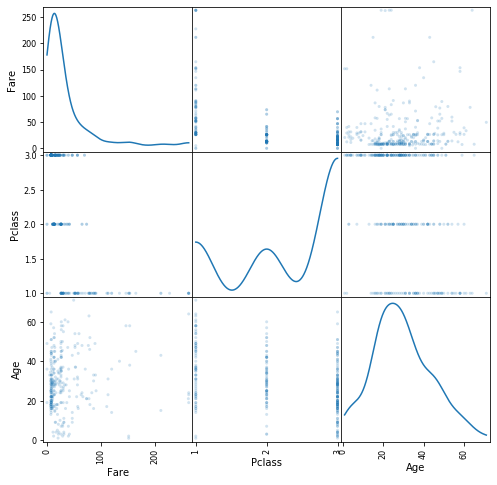

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(data.get(['Fare', 'Pclass', 'Age']), alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Non-linearly transformed data

The `Fare` variable has a very heavy tail. We can log-transform it. 

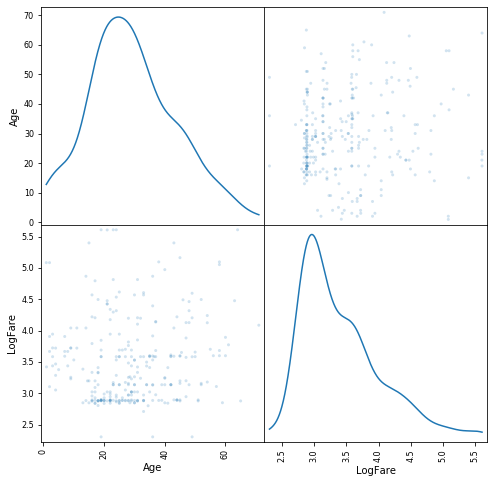

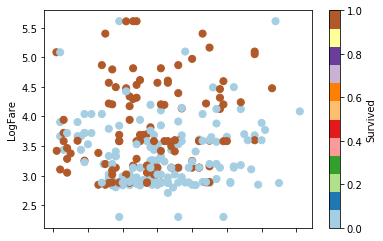

In [7]:
data_plot = data.get(['Age', 'Survived'])
data_plot = data.assign(LogFare=lambda x : np.log(x.Fare + 10.))
scatter_matrix(data_plot.get(['Age', 'LogFare']), alpha=0.2, figsize=(8, 8), diagonal='kde');

data_plot.plot(kind='scatter', x='Age', y='LogFare', c='Survived', s=50, cmap=plt.cm.Paired);

#### Plot the bivariate distributions and marginals of two variables 

Another way of visualizing relationships between variables is to plot their bivariate distributions.

/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


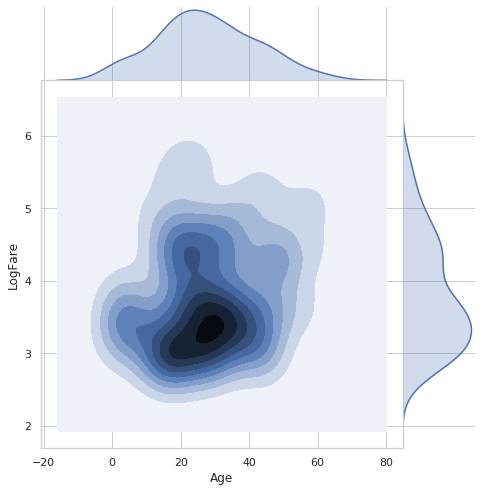

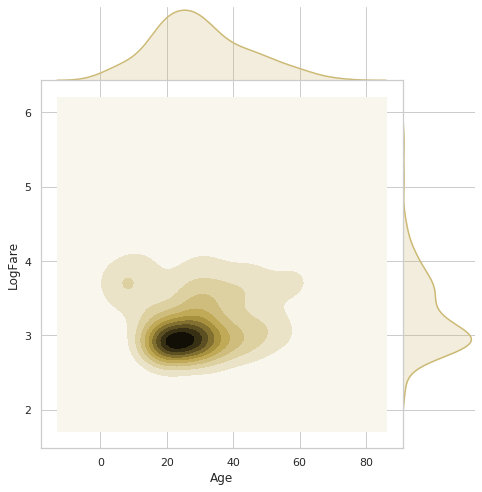

In [8]:
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot.Age[data_plot.Survived == 1],
              data_plot.LogFare[data_plot.Survived == 1],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot.Age[data_plot.Survived == 0],
              data_plot.LogFare[data_plot.Survived == 0],
              kind="kde", size=7, space=0, color="y");

## Making predictions

A basic prediction workflow, using scikit-learn, will be presented below.

First, we will perform some simple preprocessing of our data:

* [one-hot encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) the categorical features: `Sex`, `Pclass`, `Embarked`
* for the numerical columns `Age`, `SibSp`, `Parch`, `Fare`, fill in missing values with a default value (`-1`)
* all remaining columns will be dropped

This can be done succintly with [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) which performs specific transformations on specific features.

In [9]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

categorical_cols = ['Sex', 'Pclass', 'Embarked']
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    (SimpleImputer(strategy='constant', fill_value=-1), numerical_cols),
)

The `preprocessor` object created with `make_column_transformer` can be used in a scikit-learn [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). A `pipeline` assembles several steps together and can be used to cross validate an entire workflow. Generally, transformation steps are combined with a final estimator.

We will create a pipeline consisting of the `preprocessor` created above and a final estimator, `LogisticRegression`.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('transformer', preprocessor),
    ('classifier', LogisticRegression()),
])

We can cross-validate our `pipeline` using `cross_val_score`. Below we will have specified `cv=8` meaning KFold cross-valdiation splitting will be used, with 8 folds. The Area Under the Receiver Operating Characteristic Curve (ROC AUC) score is calculated for each split. The output `score` will be an array of 8 scores from each KFold. The score mean and standard of the 8 scores is printed at the end.

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X_train, y_train, cv=8, scoring='roc_auc')

print("mean: %e (+/- %e)" % (scores.mean(), scores.std()))

mean: 8.429622e-01 (+/- 4.619170e-02)


/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: 

### Testing

Once you have created a model with cross-valdiation scores you are happy with, you can test how well your model performs on the independent test data.

First we will read in our test data:

In [12]:
test_filename = 'data/test.csv'
data = pd.read_csv(test_filename)
y_test = data['Survived'].values
X_test = data.drop(['Survived', 'PassengerId'], axis=1)
X_test.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S
1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
2,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
3,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S
4,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C


Next we need to fit our pipeline on our training data:

In [13]:
clf = pipeline.fit(X_train, y_train)

/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Now we can predict on our test data:

In [14]:
y_pred = pipeline.predict(X_test)

Finally, we can calculate how well our model performed on the test data:

In [15]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, y_pred)
score

0.8187165775401071

## RAMP submissions

For submitting to the [RAMP site](http://ramp.studio), you will need to write a `submission.py` file that defines a `get_estimator` function that returns a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

For example, to submit our basic example above, we would define our `pipeline` within the function and return the pipeline at the end. Remember to include all the necessary imports at the beginning of the file.

In [16]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def get_estimator():

    categorical_cols = ['Sex', 'Pclass', 'Embarked']
    numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

    preprocessor = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        (SimpleImputer(strategy='constant', fill_value=-1), numerical_cols),
    )

    pipeline = Pipeline([
        ('transformer', preprocessor),
        ('classifier', LogisticRegression()),
    ])

    return pipeline

If you take a look at the sample submission in the directory `submissions/starting_kit`, you will find a file named `submission.py`, which has the above code in it.

You can test that the sample submission works by running `ramp_test_submission` in your terminal (ensure that `ramp-workflow` has been installed and you are in the `titanic` ramp kit directory). Alternatively, within this notebook you can run:

In [17]:
!ramp_test_submission

Traceback (most recent call last):
  File "/home/lucy/miniconda3/envs/FAN/bin/ramp_test_submission", line 10, in <module>
    sys.exit(ramp_test_submission())
  File "/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/rampwf/utils/command_line.py", line 104, in ramp_test_submission
    retrain=retrain)
  File "/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/rampwf/utils/testing.py", line 87, in assert_submission
    problem = assert_read_problem(ramp_kit_dir)
  File "/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/rampwf/utils/testing.py", line 31, in assert_read_problem
    os.path.join(ramp_kit_dir, 'problem.py'))
  File "/home/lucy/miniconda3/envs/FAN/lib/python3.7/imp.py", line 171, in load_source
    module = _load(spec)
  File "<frozen importlib._bootstrap>", line 696, in _load
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootst

To test that your own submission works, create a new folder within `submissions` and name it how you wish. Within your new folder save your `submission.py` file that defines a `get_estimator` function. Test your submission locally by running:

`ramp_test_submission --submission <folder>`

where `<folder>` is the name of the new folder you created above.

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good solution, you can submit it to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then, find the appropriate open event for the [titanic](http://www.ramp.studio/events/titanic) challenge. Sign up for the event. Note that both RAMP and event signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request(s) have been accepted, you can go to your [sandbox](http://www.ramp.studio/events/titanic/sandbox) and copy-paste (or upload) your `submissions.py` file. Save your submission, name it, then click 'submit'. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/titanic/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/titanic/leaderboard).

If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/titanic/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual workflow with RAMP is to explore solutions by refining feature transformations, selecting different models and perhaps do some AutoML/hyperopt, etc., in a notebook setting, then test them with `ramp_test_submission`. The script prints mean cross-validation scores:

```
----------------------------
train auc = 0.85 ± 0.005
train acc = 0.81 ± 0.006
train nll = 0.45 ± 0.007
valid auc = 0.87 ± 0.023
valid acc = 0.81 ± 0.02
valid nll = 0.44 ± 0.024
test auc = 0.83 ± 0.006
test acc = 0.76 ± 0.003
test nll = 0.5 ± 0.005
```

The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/titanic/leaderboard)) is area under the roc curve ("auc"), so the line that is relevant in the output of `ramp_test_submission` is `valid auc = 0.87 ± 0.023`.

## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=titanic notebook).